# BCC Multiple Samples

In [1]:
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy.io
import os
import anndata as ad # Anndata version must > 0.8
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

import scATAnno
from scATAnno.SnapATAC2_spectral import *
from scATAnno.SnapATAC2_tools import *
from scATAnno.SnapATAC2_utils import *
from scATAnno import scATAnno_preprocess
from scATAnno import scATAnno_assignment
from scATAnno import scATAnno_integration
from scATAnno import scATAnno_plotting

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

default_28 = scATAnno_plotting.get_palettes("default28")
default_102 = scATAnno_plotting.get_palettes("default102")

### Part I: First round annotation - Apply Healthy Adult reference atlas to BCC tumor samples

We first apply healthy adult reference atlas to two BCC samples. We load reference atlas data and BCC query data with healthy adult reference peak as feature input. Reference atlas is stored as h5ad AnnData in the data directory; query data is imported as MTX and TSV files from QuickATAC output.

Download reference data

In [ ]:
# !wget "https://www.dropbox.com/s/3ezp2t6gw6hw21v/Healthy_Adult_reference_atlas.h5ad?dl=1"

Download query data. Each BCC sample has two features, one aligned with Healthy adult reference peak, and the other aligned with BCC TIL reference peak.

In [1]:
# !wget "https://www.dropbox.com/sh/dwn0ynon4bzzj4t/AAB8ei6223oIWC14ry_lNdSma?dl=1"

In [3]:
os.chdir("scATAnno-main")

output_name = "BCC_samples"
out_dir = os.path.join("case_study", output_name)

reference_data_path = "data/Reference/Healthy_Adult_reference_atlas.h5ad"
reference_data = scATAnno_preprocess.load_reference_data(reference_data_path)
SU007_Total_Post = scATAnno_preprocess.import_query_data(path = 'data/BCC_samples/SU007_Total_Post_vHealthyAdult',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv.gz',
                                    features_file = 'features.tsv.gz', 
                                    variable_prefix = "SU007_Total_Post", 
                                    celltype_col = "celltypes",
                                    add_metrics=False)
SU010_Total_Pre = scATAnno_preprocess.import_query_data(path = 'data/BCC_samples/SU010_Total_Pre_vHealthyAdult',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv',
                                    features_file = 'features.tsv.gz', 
                                    variable_prefix = "SU010_Total_Pre", 
                                    celltype_col = "celltypes",
                                    add_metrics=False)

In [35]:
print(SU010_Total_Pre)
print(SU007_Total_Post)
print(reference_data)

assert reference_data.var.shape[0] == SU010_Total_Pre.var.shape[0]
assert reference_data.var.shape[0] == SU007_Total_Post.var.shape[0]

AnnData object with n_obs × n_vars = 1071 × 890130
    obs: 'celltypes', 'tissue', 'dataset'
    var: 'selected'
AnnData object with n_obs × n_vars = 666 × 890130
    obs: 'celltypes', 'tissue', 'dataset'
    var: 'selected'
AnnData object with n_obs × n_vars = 100158 × 890130
    obs: 'celltypes', 'tissue', 'dataset'
    var: 'selected'
    uns: 'cell type_colors', 'major cell type_colors', 'spectral_eigenvalue', 'tissue_colors'
    obsm: 'X_umap'


We first create a dictionary of reference and query datasets

In [6]:
data_list = [SU007_Total_Post, SU010_Total_Pre]
print("total number of query cells: {}".format(np.sum([i.obs.shape[0] for i in data_list])))

total number of query cells: 1737


Before integration, we need to select features of datasets and prepare for integration

In [7]:
select_features(reference_data)
for anndata in data_list:
    select_features(anndata) 

datasets={}
datasets["Atlas"] = reference_data
for anndata in data_list:
    key = (anndata.obs["dataset"])[0]
    datasets[key] = anndata
datasets

/Users/jiang/Dropbox (Partners HealthCare)/Software/ATAC_Annotation_V3/ATAC_Annotation_Package/scATAnno/SnapATAC2_spectral.py:159: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["selected"] = selected_features
/Users/jiang/Dropbox (Partners HealthCare)/Software/ATAC_Annotation_V3/ATAC_Annotation_Package/scATAnno/SnapATAC2_spectral.py:159: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["selected"] = selected_features


{'Atlas': AnnData object with n_obs × n_vars = 100158 × 890130
     obs: 'Unnamed: 0', 'sample', 'replicate', 'logUMI', 'tsse', 'tissue', 'cell type', 'Life stage', 'major cell type', 'dataset'
     var: 'selected'
     uns: 'cell type_colors', 'major cell type_colors', 'spectral_eigenvalue', 'tissue_colors'
     obsm: 'X_umap',
 'SU007_Total_Post': AnnData object with n_obs × n_vars = 666 × 890130
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected',
 'SU010_Total_Pre': AnnData object with n_obs × n_vars = 1071 × 890130
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected'}

We use SnapATAC2 to integrate the reference atlas and multiple query data

In [8]:
# Integrate reference and query data
integrated_adata = scATAnno_assignment.scATAnno_integrate_multiple(datasets, sample_size = 25000)

Compute similarity matrix
Normalization
Perform decomposition
Perform Nystrom extension


100%|█████████████████████████████████████████████| 6/6 [05:55<00:00, 59.27s/it]


Apply harmony to remove batch effects of datasets

In [10]:
# Apply harmony to remove batch effects
integrated_adata_harmony = scATAnno_assignment.scATAnno_harmony(integrated_adata, batch_col = "dataset")

2023-05-25 14:11:10,406 - harmonypy - INFO - Iteration 1 of 20
2023-05-25 14:11:31,432 - harmonypy - INFO - Iteration 2 of 20
2023-05-25 14:11:52,638 - harmonypy - INFO - Converged after 2 iterations


Plot UMAP using spectral embeddings

In [47]:
# Plot UMAP using spectral embeddings
integrated_adata = scATAnno_assignment.scATAnno_umap(integrated_adata_harmony, out_dir, use_rep = "X_spectral_harmony", save = True)

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


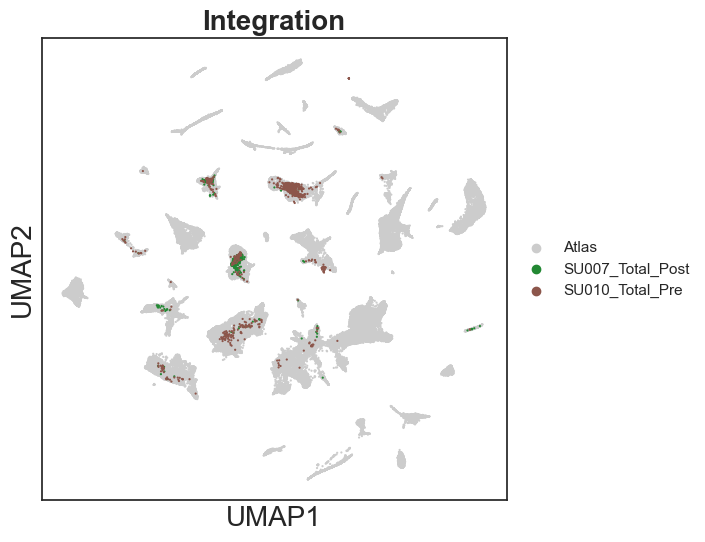

In [16]:
# Set plotting parameters
scATAnno_plotting.defaultPlotting_umap()
sc.pl.umap(integrated_adata, color="dataset", palette = ['#cccccc', '#228833','#8c564b'], size=10, show=True, title = "Integration")

In [46]:
integrated_adata.obs

,tissue,dataset,celltypes
adipose_omentum_SM-CSSD4_1+AAGTCCTTAGGGCTGATATGCT_Atlas,adipose_omentum_SM-CSSD4,Atlas,Mesenchymal
adipose_omentum_SM-CSSD4_1+AACGACCAAAGGCGTACTTCTA_Atlas,adipose_omentum_SM-CSSD4,Atlas,Mesenchymal
adipose_omentum_SM-IOBHJ_1+ATACTCGCTTAGCGGCTGAAAC_Atlas,adipose_omentum_SM-IOBHJ,Atlas,Mesenchymal
adipose_omentum_SM-CSSD4_1+CAGGAAAGCAAAAGGGATGCCA_Atlas,adipose_omentum_SM-CSSD4,Atlas,Mesenchymal
adipose_omentum_SM-IOBHJ_1+ATGCAGGTAAATAGCTGTGTCT_Atlas,adipose_omentum_SM-IOBHJ,Atlas,Mesenchymal
...,...,...,...
SU010_Total_Pre#TGGGTTATCCCAGCAG-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre
SU010_Total_Pre#GGGTGTCTCGGGACAA-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre
SU010_Total_Pre#ACCGGGTCATCCCAAA-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre
SU010_Total_Pre#CCCGTTATCTAGCAGT-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre


In [51]:
reference = integrated_adata[integrated_adata.obs['dataset'] == "Atlas",:].copy()
reference.obs["celltypes"] =  scATAnno_assignment.curate_celltype_names(reference.obs["celltypes"], atlas = "HealthyAdult")

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


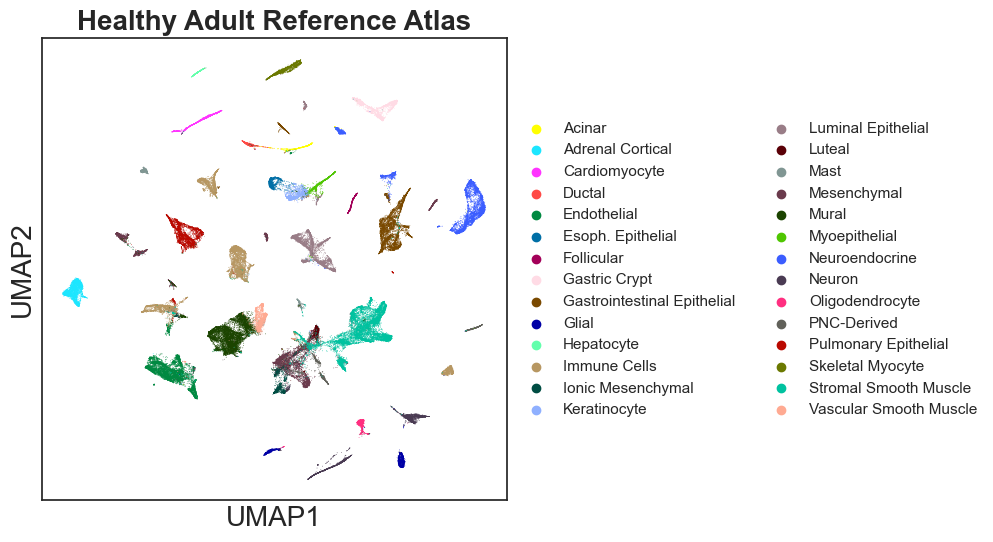

In [61]:
import pickle
with open(os.path.join(out_dir, 'HealthyAdult_reference_palette.pickle'), 'rb') as handle:
    celltype_palette = pickle.load(handle)

scATAnno_plotting.defaultPlotting_umap()
sc.pl.umap(reference, color="celltypes", palette = celltype_palette, title = "Healthy Adult Reference Atlas")

After integration, we want to assign cell types to the query data. First, query cells are assigned labels using K-Nearest neighbors along with KNN-based uncertainty score. Second, query cell labels are corrected using weighted-distance-based uncertainty score. Third, query cells are clustered and annotated at the cluster level.

In [62]:
query = integrated_adata[integrated_adata.obs['dataset'] != "Atlas",:].copy()

Obtain UMAP coordinates and clusters provided by the original publication. Then Query cells are clustered and annotated at the cluster-level

In [71]:
projection_allcells = pd.read_table("data/BCC_samples/BCC_study_metadata.csv", index_col = 0, sep = ",")
projection_allcells.index = [projection_allcells.loc[i,"Group"] + "#" + i for i in projection_allcells.index]
sample_names = ["SU010_Total_Pre", "SU007_Total_Post"]
projection = projection_allcells[projection_allcells["Group"].isin(sample_names)]
query.obs = pd.merge(query.obs, projection, left_index=True, right_index=True)
projection.head()

,UMAP_1,UMAP_2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name,Group_Barcode,true_label
SU007_Total_Post#GGACACCAGCGCACAA-1_SU007_Total_Post,1.320694,12.943564,Cluster14,SU007_Total_Post,50427,0.676443,GGACACCAGCGCACAA-1,SU007_Total_Post_57,SU007_Total_Post#GGACACCAGCGCACAA-1,Myeloid
SU007_Total_Post#ACTAGGTGTACCCATA-1_SU007_Total_Post,5.631482,13.093065,Cluster15,SU007_Total_Post,45889,0.580553,ACTAGGTGTACCCATA-1,SU007_Total_Post_59,SU007_Total_Post#ACTAGGTGTACCCATA-1,Endothelial
SU007_Total_Post#AGGACGATCGGTCTCT-1_SU007_Total_Post,1.471412,-7.473051,Cluster4,SU007_Total_Post,21568,0.688590,AGGACGATCGGTCTCT-1,SU007_Total_Post_60,SU007_Total_Post#AGGACGATCGGTCTCT-1,Treg
SU007_Total_Post#GACCAATCATGGGTGA-1_SU007_Total_Post,-4.932662,2.046299,Cluster7,SU007_Total_Post,25402,0.714097,GACCAATCATGGGTGA-1,SU007_Total_Post_61,SU007_Total_Post#GACCAATCATGGGTGA-1,Memory CD8 T
SU007_Total_Post#GCTCGAGAGTAATGTG-1_SU007_Total_Post,-4.171803,3.467478,Cluster7,SU007_Total_Post,6544,0.714318,GCTCGAGAGTAATGTG-1,SU007_Total_Post_62,SU007_Total_Post#GCTCGAGAGTAATGTG-1,Memory CD8 T


We first assign cell types based on KNN and compute KNN-based uncertainty score

In [72]:
# Perform KNN assignment
query_KNN = scATAnno_assignment.scATAnno_KNN_assign(reference, query, reference_label_col=reference_label_col, low_dim_col=use_rep)

Query cells are assigned high weighted distance-based uncertainty score if their distances to the assigned reference cell type centroid are greater than 90 percentile. Query cells with uncertainty score greater than 0.2 are annotated as unknown.

In [73]:
# Perform weighted-distance based assignment
distance_threshold = 90
uncertainty_threshold = 0.2
reference_label_col = "celltypes"
use_rep = "X_spectral_harmony"
atlas = "HealthyAdult"
query_distance = scATAnno_assignment.scATAnno_distance_assign(reference, query_KNN, reference_label_col=reference_label_col, distance_threshold=distance_threshold, atlas=atlas, uncertainty_threshold=uncertainty_threshold, use_rep = use_rep)

We then project query cells into the same UMAP coordinates as original publication for better comparisons, and perform cluster-level assignment.

In [85]:
query_distance.obsm["X_umap"] = np.array(query_distance.obs[["UMAP_1", "UMAP_2"]])
query_annotated = scATAnno_assignment.scATAnno_cluster_assign(query_distance, use_rep=use_rep, cluster_col = "Clusters", UMAP=False)
query_annotated

AnnData object with n_obs × n_vars = 1737 × 890130
    obs: 'tissue', 'dataset', 'celltypes', 'uncertainty_score_step1', 'pred_y', 'uncertainty_score_step2', 'Uncertainty_Score', '1.knn-based_celltype', '2.corrected_celltype', 'UMAP_1', 'UMAP_2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'Group_Barcode', 'true_label', 'cluster_annotation'
    uns: 'dataset_colors'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap', 'kernel_distance', 'distance', 'indices', 'neighbors_labels'

Compare annotation results from scATAnno and the origional publication

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


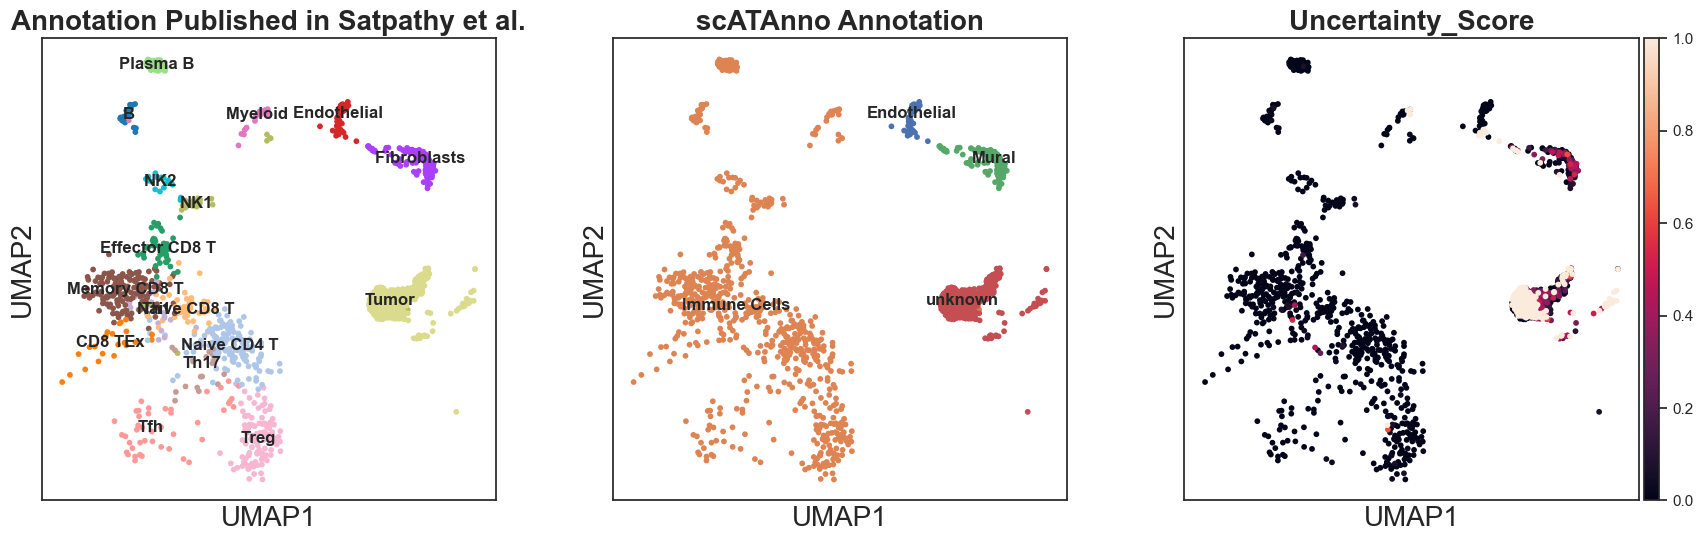

In [95]:
sc.pl.umap(query_annotated, color = ['true_label', "cluster_annotation", 'Uncertainty_Score'], title = ["Annotation Published in Satpathy et al.","scATAnno Annotation"], legend_loc = "on data")

In [129]:
immune_cells = pd.DataFrame(query_annotated[query_annotated.obs["cluster_annotation"] == "Immune Cells"].obs.index)
print(immune_cells.head())

                                                   0
0  SU007_Total_Post#TCGTTCGAGGTTCTCA-1_SU007_Tota...
1  SU007_Total_Post#GCAACCGAGAAGAGTG-1_SU007_Tota...
2  SU007_Total_Post#GTGTCAAGTTAGTAGA-1_SU007_Tota...
3  SU007_Total_Post#CTTGTCGAGCGAGCTA-1_SU007_Tota...
4  SU007_Total_Post#GCAGCTGCATTCGTCC-1_SU007_Tota...


### Part II: Second round annotation - Apply BCC TIL reference atlas to BCC immune cells

Download TIL reference data

In [2]:
# !wget "https://www.dropbox.com/s/ky4jezsj3pf2qwi/BCC_TIL_reference_atlas_final.h5ad?dl=1"

In the second round annotation, we apply BCC TIL reference atlas to the immune cells identified from the first round. Repeat the integration process. This time we use BCC TIL as reference, and use BCC query data with TIL reference peak as feature input. Reference atlas is stored as h5ad AnnData in the data directory; query data is imported as MTX and TSV files from QuickATAC output.

In [108]:
reference_data_path = "data/Reference/BCC_TIL_reference_atlas_final.h5ad"
reference_data = scATAnno_preprocess.load_reference_data(reference_data_path)
SU007_Total_Post = scATAnno_preprocess.import_query_data(path = 'data/BCC_samples/SU007_Total_Post_vBCC',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv.gz',
                                    features_file = 'features.tsv.gz', 
                                    variable_prefix = "SU007_Total_Post", 
                                    celltype_col = "celltypes",
                                    add_metrics=False)
SU010_Total_Pre = scATAnno_preprocess.import_query_data(path = 'data/BCC_samples/SU010_Total_Pre_vBCC',
                                    mtx_file = 'matrix.mtx.gz',
                                    cells_file = 'barcodes.tsv',
                                    features_file = 'features.tsv.gz', 
                                    variable_prefix = "SU010_Total_Pre", 
                                    celltype_col = "celltypes",
                                    add_metrics=False)

In [132]:
data_list = [SU007_Total_Post, SU010_Total_Pre]
print("Total number of query cells: {}".format(np.sum([i.obs.shape[0] for i in data_list])))

Total number of query cells: 1737


Select the immune cells from first round annotation

In [130]:
immune_cells.index = immune_cells[0]
immune_cells.index = [i.split("_SU")[0] for i in immune_cells.index]
immune_cells.head()

,0
SU007_Total_Post#TCGTTCGAGGTTCTCA-1,SU007_Total_Post#TCGTTCGAGGTTCTCA-1_SU007_Tota...
SU007_Total_Post#GCAACCGAGAAGAGTG-1,SU007_Total_Post#GCAACCGAGAAGAGTG-1_SU007_Tota...
SU007_Total_Post#GTGTCAAGTTAGTAGA-1,SU007_Total_Post#GTGTCAAGTTAGTAGA-1_SU007_Tota...
SU007_Total_Post#CTTGTCGAGCGAGCTA-1,SU007_Total_Post#CTTGTCGAGCGAGCTA-1_SU007_Tota...
SU007_Total_Post#GCAGCTGCATTCGTCC-1,SU007_Total_Post#GCAGCTGCATTCGTCC-1_SU007_Tota...


In [133]:
data_list_use = data_list.copy()
for i in range(len(data_list_use)):
    print(data_list_use[i].obs["dataset"][0])
    data_list_use[i] = data_list_use[i][data_list_use[i].obs.index.isin(immune_cells.index)]
    print(data_list_use[i])

print("Total immune cells: {}".format(np.sum([i.obs.shape[0] for i in data_list_use])))

SU007_Total_Post
View of AnnData object with n_obs × n_vars = 618 × 344492
    obs: 'celltypes', 'tissue', 'dataset'
    var: 'selected'
SU010_Total_Pre
View of AnnData object with n_obs × n_vars = 188 × 344492
    obs: 'celltypes', 'tissue', 'dataset'
    var: 'selected'
Total immune cells: 806


We use SnapATAC2 to integrate the reference atlas and multiple query data

In [134]:
for anndata in data_list_use:
    select_features(anndata) 
select_features(reference_data)

datasets={}
datasets["Atlas"] = reference_data
for anndata in data_list_use:
    key = (anndata.obs["dataset"])[0]
    datasets[key] = anndata
datasets

/Users/jiang/Dropbox (Partners HealthCare)/Software/ATAC_Annotation_V3/ATAC_Annotation_Package/scATAnno/SnapATAC2_spectral.py:159: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["selected"] = selected_features


{'Atlas': AnnData object with n_obs × n_vars = 22008 × 344492
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected'
     uns: 'Group_colors', 'celltypes_colors', 'spectral_eigenvalue', 'true_label_colors'
     obsm: 'X_spectral', 'X_umap',
 'SU007_Total_Post': AnnData object with n_obs × n_vars = 618 × 344492
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected',
 'SU010_Total_Pre': AnnData object with n_obs × n_vars = 188 × 344492
     obs: 'celltypes', 'tissue', 'dataset'
     var: 'selected'}

In [135]:
# Integrate reference and query data
integrated_adata = scATAnno_assignment.scATAnno_integrate_multiple(datasets, sample_size = 25000)

Compute similarity matrix
Normalization
Perform decomposition


In [136]:
# Apply harmony to remove batch effects
integrated_adata_harmony = scATAnno_assignment.scATAnno_harmony(integrated_adata, batch_col = "dataset")

2023-05-25 15:23:46,290 - harmonypy - INFO - Iteration 1 of 20
2023-05-25 15:23:49,706 - harmonypy - INFO - Iteration 2 of 20
2023-05-25 15:23:53,264 - harmonypy - INFO - Iteration 3 of 20
2023-05-25 15:23:56,800 - harmonypy - INFO - Iteration 4 of 20
2023-05-25 15:24:00,334 - harmonypy - INFO - Iteration 5 of 20
2023-05-25 15:24:03,925 - harmonypy - INFO - Iteration 6 of 20
2023-05-25 15:24:07,365 - harmonypy - INFO - Iteration 7 of 20
2023-05-25 15:24:11,058 - harmonypy - INFO - Converged after 7 iterations


In [137]:
# Plot UMAP using spectral embeddings
integrated_adata = scATAnno_assignment.scATAnno_umap(integrated_adata_harmony, out_dir, use_rep = "X_spectral_harmony", save = True)

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


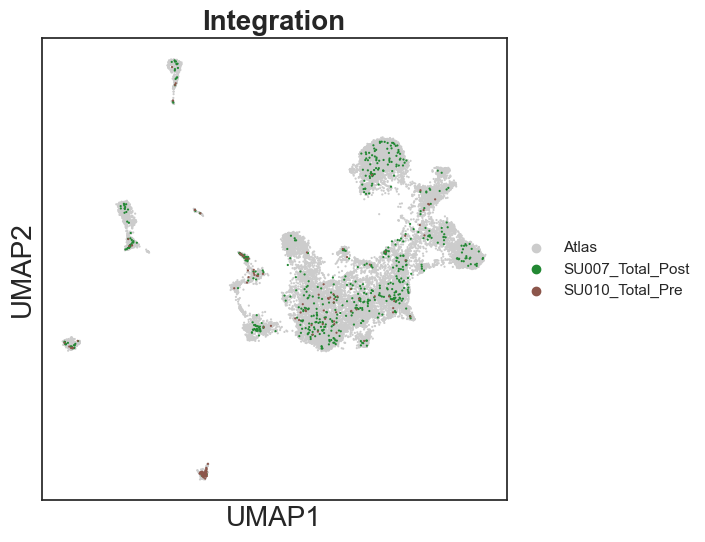

In [138]:
# Set plotting parameters
scATAnno_plotting.defaultPlotting_umap()
sc.pl.umap(integrated_adata, color="dataset", palette = ['#cccccc', '#228833','#8c564b'], size=10, show=True, title = "Integration")

In [145]:
reference = integrated_adata[integrated_adata.obs['dataset'] == "Atlas",:].copy()
reference.obs["celltypes"] =  scATAnno_assignment.curate_celltype_names(reference.obs["celltypes"], atlas = "TIL")

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


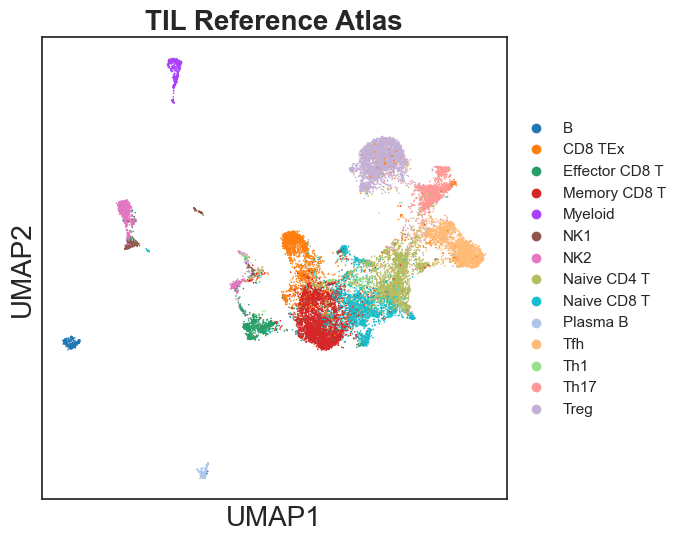

In [144]:
import pickle
with open(os.path.join(out_dir, 'TIL_reference_palette.pickle'), 'rb') as handle:
    celltype_palette = pickle.load(handle)

scATAnno_plotting.defaultPlotting_umap()
sc.pl.umap(reference, color="celltypes", palette = celltype_palette, title = "TIL Reference Atlas")

In [146]:
query = integrated_adata[integrated_adata.obs['dataset'] != "Atlas",:].copy()

In [147]:
projection_allcells = pd.read_table("data/BCC_samples/BCC_study_metadata.csv", index_col = 0, sep = ",")
projection_allcells.index = [projection_allcells.loc[i,"Group"] + "#" + i for i in projection_allcells.index]
projection_allcells["true_label"] = [i.strip() for i in projection_allcells["true_label"]]
sample_names = ["SU010_Total_Pre", "SU007_Total_Post"]
projection = projection_allcells[projection_allcells["Group"].isin(sample_names)]
query.obs = pd.merge(query.obs, projection, left_index=True, right_index=True)
query.obs

,celltypes,tissue,dataset,UMAP_1,UMAP_2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name,Group_Barcode,true_label
SU007_Total_Post#TCGTTCGAGGTTCTCA-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,2.118399,-6.020474,Cluster4,SU007_Total_Post,10159,0.722758,TCGTTCGAGGTTCTCA-1,SU007_Total_Post_312,SU007_Total_Post#TCGTTCGAGGTTCTCA-1,Treg
SU007_Total_Post#GCAACCGAGAAGAGTG-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,2.138090,-8.092027,Cluster4,SU007_Total_Post,12455,0.715857,GCAACCGAGAAGAGTG-1,SU007_Total_Post_1,SU007_Total_Post#GCAACCGAGAAGAGTG-1,Treg
SU007_Total_Post#GTGTCAAGTTAGTAGA-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,0.018025,-1.757976,Cluster1,SU007_Total_Post,9101,0.621910,GTGTCAAGTTAGTAGA-1,SU007_Total_Post_468,SU007_Total_Post#GTGTCAAGTTAGTAGA-1,Naive CD4 T
SU007_Total_Post#CTTGTCGAGCGAGCTA-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,-1.315312,1.582670,Cluster5,SU007_Total_Post,22287,0.669695,CTTGTCGAGCGAGCTA-1,SU007_Total_Post_3,SU007_Total_Post#CTTGTCGAGCGAGCTA-1,Naive CD8 T
SU007_Total_Post#GCAGCTGCATTCGTCC-1_SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,SU007_Total_Post,0.688227,-1.430185,Cluster1,SU007_Total_Post,22482,0.693866,GCAGCTGCATTCGTCC-1,SU007_Total_Post_4,SU007_Total_Post#GCAGCTGCATTCGTCC-1,Naive CD4 T
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SU010_Total_Pre#CCAGATAAGTACGCGA-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,-3.657552,2.379094,Cluster7,SU010_Total_Pre,6428,0.583852,CCAGATAAGTACGCGA-1,SU010_Total_Pre_1057,SU010_Total_Pre#CCAGATAAGTACGCGA-1,Memory CD8 T
SU010_Total_Pre#ACAGGCCTCAAGAGAT-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,-3.117948,1.990111,Cluster5,SU010_Total_Pre,3820,0.529188,ACAGGCCTCAAGAGAT-1,SU010_Total_Pre_1058,SU010_Total_Pre#ACAGGCCTCAAGAGAT-1,Naive CD8 T
SU010_Total_Pre#TGGGTTATCCCAGCAG-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,-1.875685,0.338385,Cluster5,SU010_Total_Pre,4741,0.469099,TGGGTTATCCCAGCAG-1,SU010_Total_Pre_1061,SU010_Total_Pre#TGGGTTATCCCAGCAG-1,Naive CD8 T
SU010_Total_Pre#GGGTGTCTCGGGACAA-1_SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,SU010_Total_Pre,-4.008999,16.443800,Cluster13,SU010_Total_Pre,6619,0.599940,GGGTGTCTCGGGACAA-1,SU010_Total_Pre_1064,SU010_Total_Pre#GGGTGTCTCGGGACAA-1,Plasma B


We first assign cell types based on KNN and compute KNN-based uncertainty score

In [149]:
# Perform KNN assignment
reference_label_col = "celltypes"
use_rep = "X_spectral_harmony"
query_KNN = scATAnno_assignment.scATAnno_KNN_assign(reference, query, reference_label_col=reference_label_col, low_dim_col=use_rep)

Because we are annotating TIL subtypes, we adopt more loose threshold cutoffs to annotate query cells. Query cells are assigned high weighted distance-based uncertainty score if their distances to the assigned reference cell type centroid are greater than 95 percentile. Query cells with uncertainty score greater than 0.5 are annotated as unknown.

In [150]:
# Perform weighted-distance based assignment
distance_threshold = 95
uncertainty_threshold = 0.5

atlas = "HealthyAdult"
query_distance = scATAnno_assignment.scATAnno_distance_assign(reference, query_KNN, reference_label_col=reference_label_col, distance_threshold=distance_threshold, atlas=atlas, uncertainty_threshold=uncertainty_threshold, use_rep = use_rep)

We then project query cells into the same UMAP coordinates as original publication for better comparisons, and perform cluster-level assignment.

In [151]:
query_distance.obsm["X_umap"] = np.array(query_distance.obs[["UMAP_1", "UMAP_2"]])
query_annotated = scATAnno_assignment.scATAnno_cluster_assign(query_distance, use_rep=use_rep, cluster_col = "Clusters", UMAP=False)
query_annotated

AnnData object with n_obs × n_vars = 806 × 344492
    obs: 'celltypes', 'tissue', 'dataset', 'UMAP_1', 'UMAP_2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'Group_Barcode', 'true_label', 'uncertainty_score_step1', 'pred_y', 'uncertainty_score_step2', 'Uncertainty_Score', '1.knn-based_celltype', '2.corrected_celltype', 'cluster_annotation'
    uns: 'dataset_colors'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap', 'kernel_distance', 'distance', 'indices', 'neighbors_labels'

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


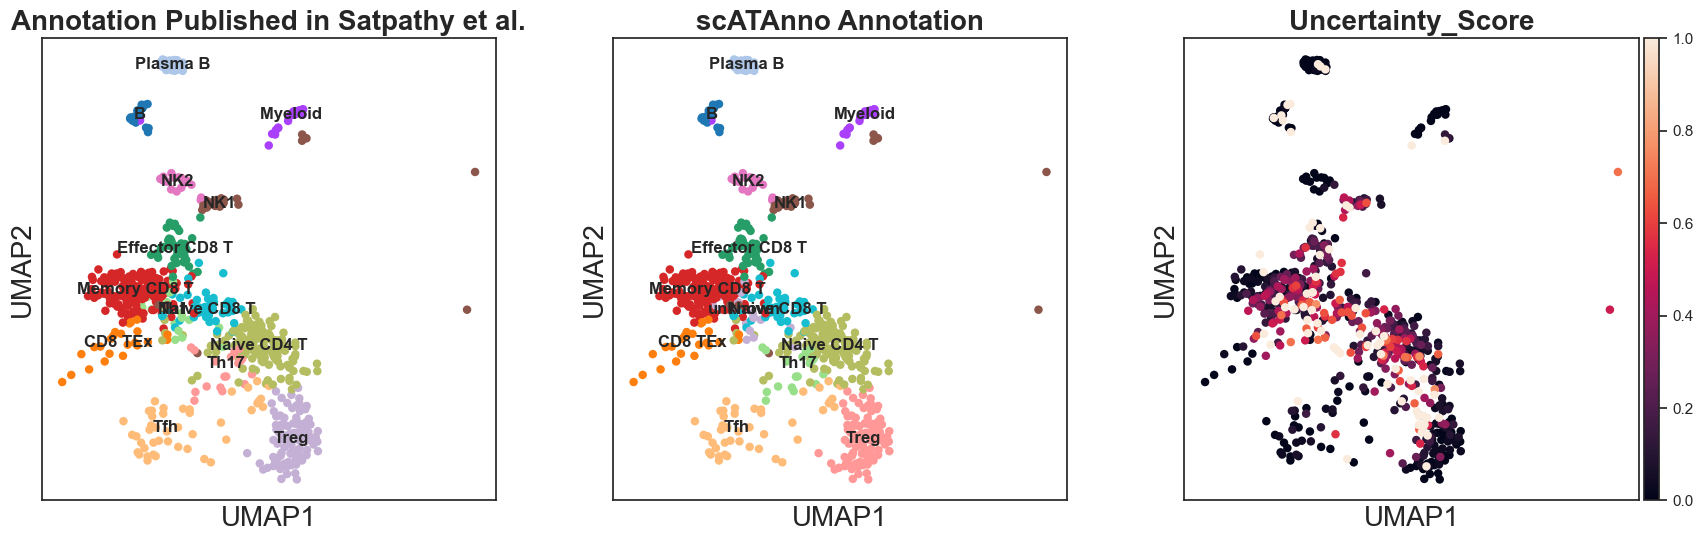

In [152]:
sc.pl.umap(query_annotated, color = ['true_label', "cluster_annotation", 'Uncertainty_Score'], title = ["Annotation Published in Satpathy et al.","scATAnno Annotation"], legend_loc = "on data")

Finally, compare the annotation results between scATAnno and original publication.

/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


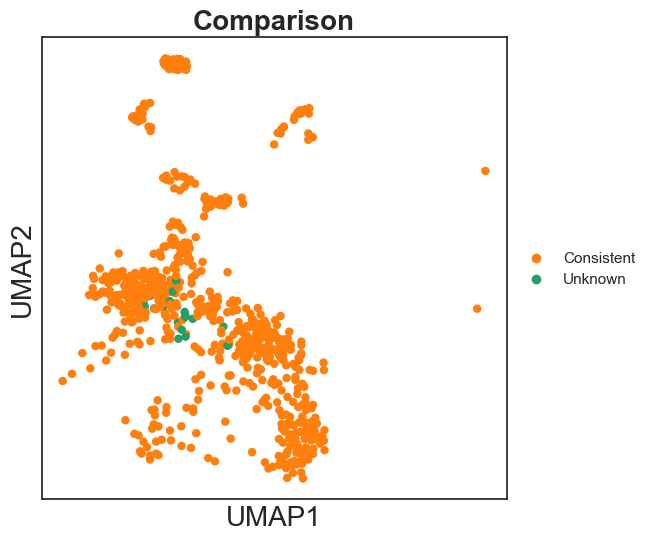

In [175]:
outcomes2 = []
for i in query_annotated.obs["cluster_annotation"].index:
    if query_annotated.obs.loc[i,"cluster_annotation"] == query_annotated.obs.loc[i,"true_label"]:
        outcomes2.append("Consistent")
    elif query_annotated.obs.loc[i,"cluster_annotation"] == "unknown":
        outcomes2.append("Unknown")
    else: 
        outcomes2.append("Inconsistent")
        
query_annotated.obs["outcomes2"] = outcomes2
sc.pl.umap(query_annotated, color = "outcomes2", palette = ['#ff7f0e','#279e68'], title = "Comparison")

/var/folders/79/yz2sgggd11n9c7kj2nws4w700000gp/T/ipykernel_5654/2520740504.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)


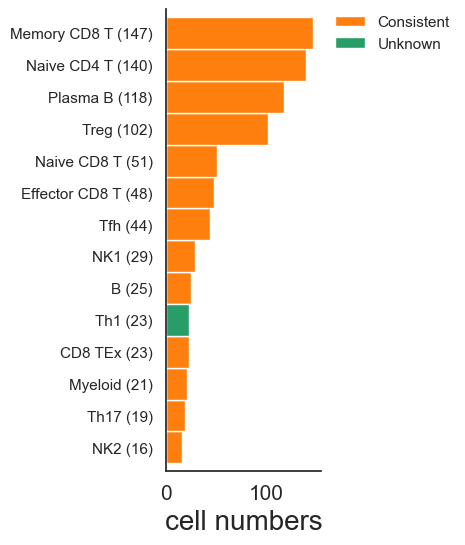

In [180]:
adata_query = query_annotated.copy()
variable_col = "true_label"
outcome_col = "outcomes2"
listdict = []
for ct in adata_query.obs[variable_col].unique():
    tmp_dict = {}
    for pt in np.unique(adata_query.obs[outcome_col]):
        tmp_dict[pt] = (
            np.sum(
                adata_query.obs[adata_query.obs[variable_col] == ct][outcome_col] == pt
            )
        )
    l = len(adata_query.obs[adata_query.obs[variable_col] == ct])
    tmp_dict['ct'] = f'{ct} ({l})'
    tmp_dict['n_cells'] = len(adata_query.obs[adata_query.obs[variable_col] == ct])
    listdict.append(tmp_dict)


df = pd.DataFrame(listdict).set_index('ct').sort_values(by='ct')
df = df.sort_values("n_cells", ascending=True)

fig, ax = plt.subplots(1, 1, figsize=(2, 6))
df[df.columns[0:len(df.columns)-1]].plot(kind='barh', stacked=True, ax=ax, width=1.0, color = ['#ff7f0e','#279e68'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_xlabel('cell numbers')
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
ax.grid(False)
sns.despine()
plt.show()

Compute accuracy and F1 scores

In [183]:
query = query_annotated.copy()
paper_anno_col="true_label"
cluster_anno_col = "cluster_annotation"
from sklearn.metrics import f1_score, confusion_matrix, classification_report
report = classification_report(y_true=query.obs[paper_anno_col],
                                       y_pred=query.obs[cluster_anno_col],
                                       output_dict=True)
#Also generate a confusion matrix
cm = confusion_matrix(y_true=query.obs[paper_anno_col],
                                       y_pred=query.obs[cluster_anno_col],)

FP = cm.sum(axis=0)-np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
class_spec = TN/(TN+FP)

perfdf = pd.DataFrame(columns = ['class', 
                                     'precision', 
                                     'recall', 
                                     'f1_score', 
                                     'support', 
                                     'specificity'])

i=0
for key, val in report.items():
    #we don't use accuracy so skip it
    if key =='accuracy': 
        continue
    perflist = []
    perflist.append(key)
    for key2, val2 in val.items():
        perflist.append(val2)
    if i>=len(class_spec):
        perflist.append(0)
    else:
        perflist.append(class_spec[i])
    perfdf=perfdf.append(pd.Series(perflist, index=perfdf.columns), ignore_index=True)
    i+=1

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_cla

In [184]:
perfdf

,class,precision,recall,f1_score,support,specificity
0,B,1.000000,1.000000,1.000000,25,1.000000
1,CD8 TEx,1.000000,1.000000,1.000000,23,1.000000
2,Effector CD8 T,1.000000,1.000000,1.000000,48,1.000000
3,Memory CD8 T,1.000000,1.000000,1.000000,147,1.000000
4,Myeloid,1.000000,1.000000,1.000000,21,1.000000
5,NK1,1.000000,1.000000,1.000000,29,1.000000
6,NK2,1.000000,1.000000,1.000000,16,1.000000
7,Naive CD4 T,1.000000,1.000000,1.000000,140,1.000000
8,Naive CD8 T,1.000000,1.000000,1.000000,51,1.000000
9,Plasma B,1.000000,1.000000,1.000000,118,1.000000


In [186]:
# Accuracy
from scATAnno import scATAnno_evaluation
df = query.obs.copy()
cell_accr = {}
for celltype_of_interest in np.unique(df[paper_anno_col]):
    true_cells = df[df[paper_anno_col]==celltype_of_interest].index
    accr = scATAnno_evaluation.compute_accuracy(df.loc[true_cells,paper_anno_col], df.loc[true_cells,cluster_anno_col])
    cell_accr[celltype_of_interest] = accr

cell_level_df = pd.DataFrame([cell_accr], columns=cell_accr.keys())
cell_level_df = cell_level_df.T
cell_level_df.columns = ["accuracy"]
cell_level_df

,accuracy
B,1.0
CD8 TEx,1.0
Effector CD8 T,1.0
Memory CD8 T,1.0
Myeloid,1.0
NK1,1.0
NK2,1.0
Naive CD4 T,1.0
Naive CD8 T,1.0
Plasma B,1.0


In [187]:
data = np.array([np.float(cell_level_df.mean()), 
                            np.float(perfdf[perfdf['class'] == "weighted avg"]["f1_score"])])

overallscore = pd.DataFrame(data.T, index = ['Accuracy', 
                                     'Weighted F1',], columns=["value"]
                             )

overallscore

,value
Accuracy,0.928571
Weighted F1,0.971464


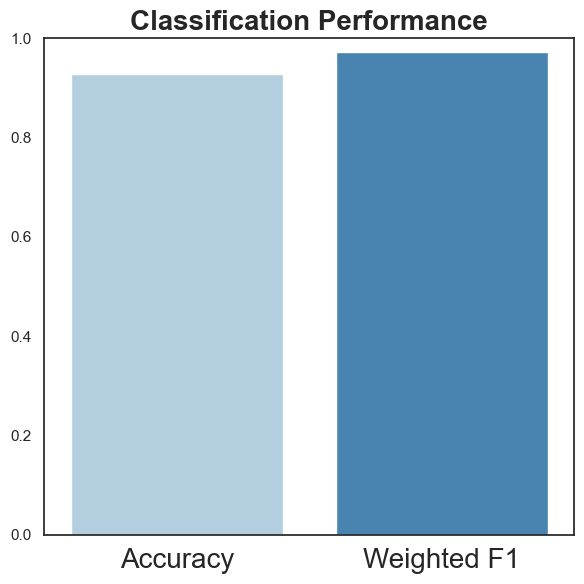

In [189]:
ax = sns.barplot(x = overallscore.index, y= overallscore["value"], capsize=.2, dodge=True, palette="Blues",
)
ax.set_title("Classification Performance")
ax.set_ylim(0,1)
ax.set_ylabel("")
fig = ax.get_figure()
fig.tight_layout()
plt.show()